In [31]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor


import holidays
import dateutil.easter as easter

In [2]:
sample_submission = pd.read_csv('./sample_submission.csv')
store = pd.read_csv('./store.csv')
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')

/tmp/ipykernel_9456/3883397479.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('./train.csv')


In [145]:
sample_submission.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [47]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekDay
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,3
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,3
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,3
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,3
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,3


In [4]:
train.describe(include='O')

,Date,StateHoliday
count,1017209,1017209
unique,942,5
top,2015-07-31,0
freq,1115,855087


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [34]:
train['StateHoliday'].value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

array([   1,    2,    3, ..., 1113, 1114, 1115])

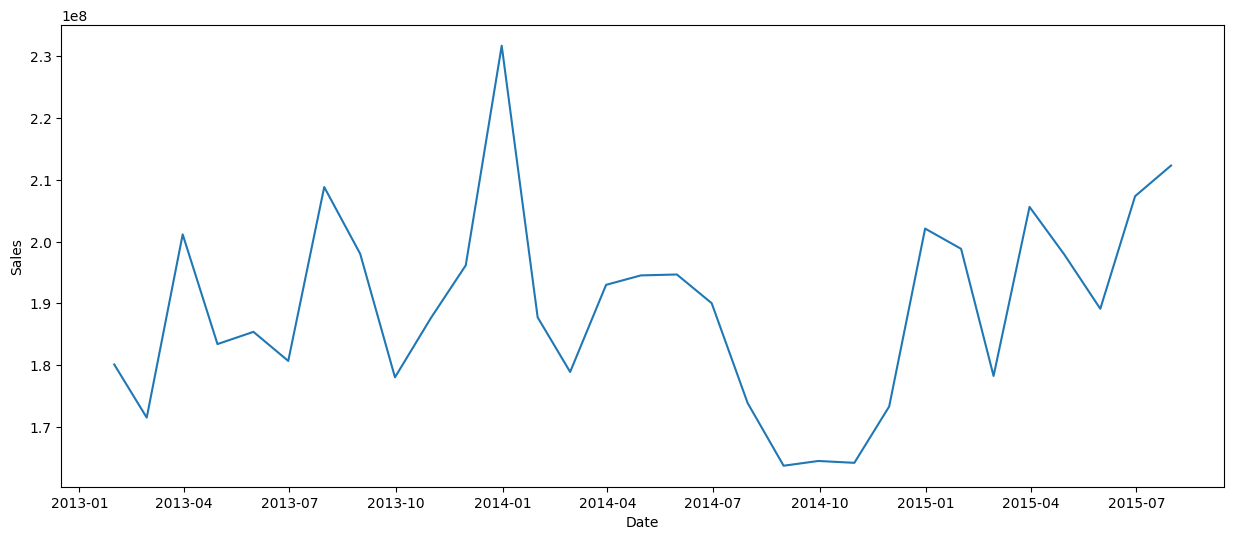

In [17]:
train['Date'] = pd.to_datetime(train['Date'])

monthly_sales = train.resample('M', on='Date')['Sales'].sum()

plt.figure(figsize=(15,6))
sns.lineplot(x = monthly_sales.index, y = monthly_sales)
plt.show();

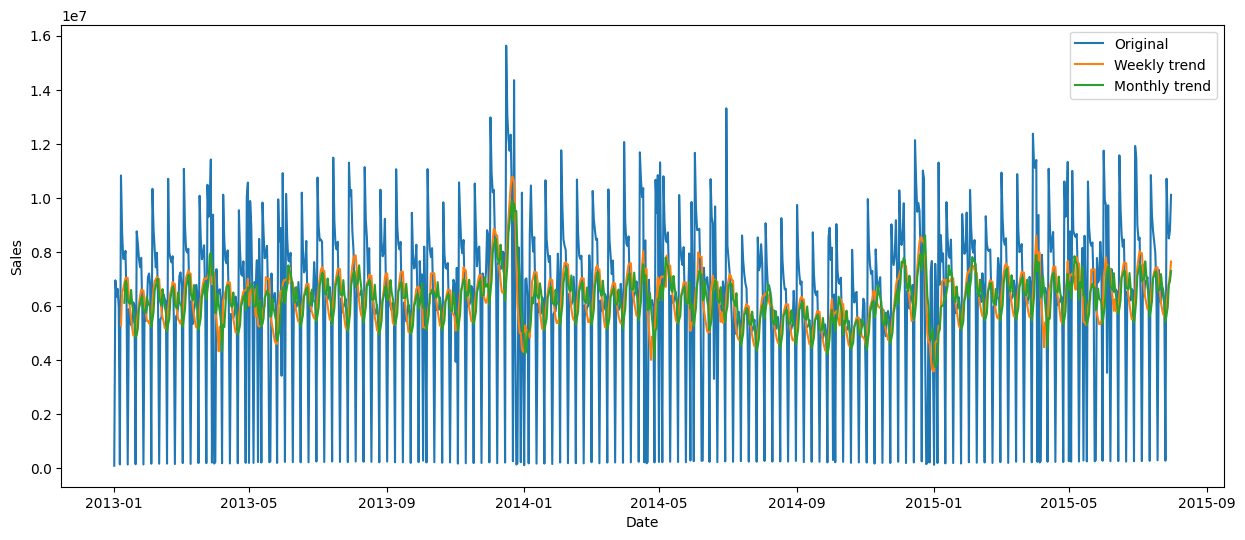

In [18]:
daily_sales = train.resample('D', on='Date')['Sales'].sum()

weekly_sales_trend = daily_sales.rolling(window=7).mean()
monthly_sales_trend = daily_sales.rolling(window=10).mean()

plt.figure(figsize=(15,6))
sns.lineplot(x=daily_sales.index, y=daily_sales, label='Original')
sns.lineplot(x=weekly_sales_trend.index, y=weekly_sales_trend, label='Weekly trend')
sns.lineplot(x=monthly_sales_trend.index, y=monthly_sales_trend, label='Monthly trend')
plt.show();

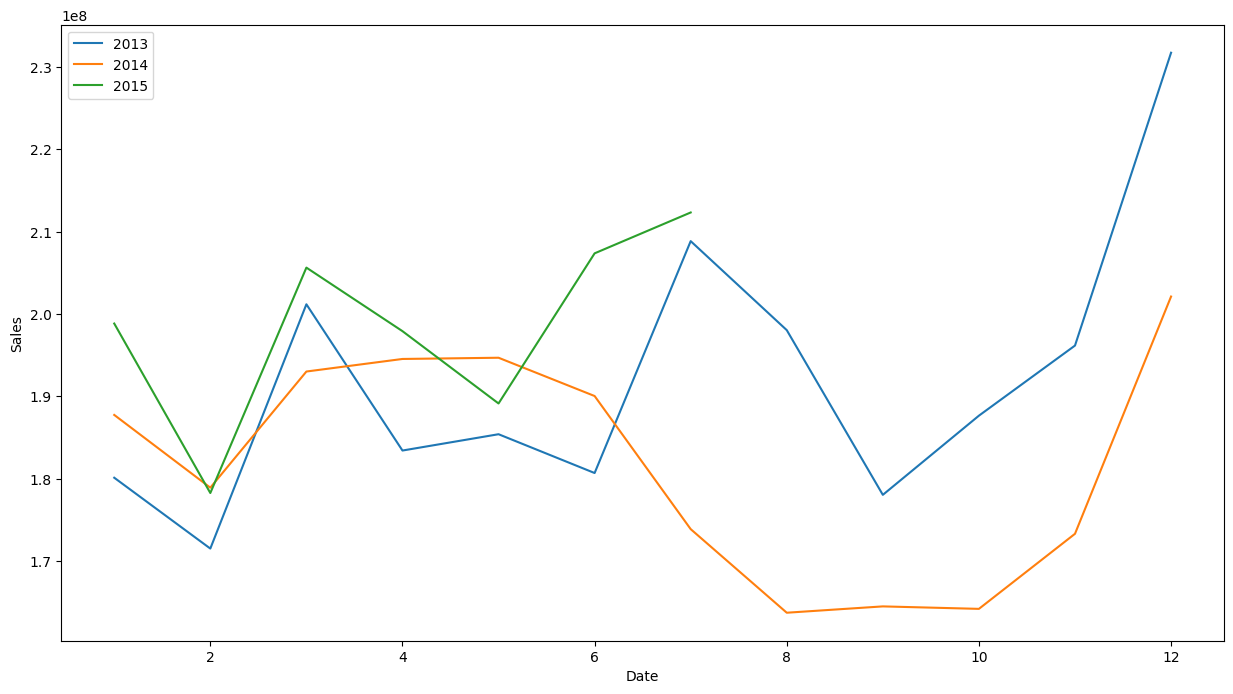

In [30]:
monthly_sales_year = train.resample('M', on='Date')['Sales'].sum().reset_index()
monthly_sales_year['year'] = monthly_sales_year['Date'].dt.year
plt.figure(figsize=(15,8))
for year in sorted(monthly_sales_year['year'].unique()):
    year_data = monthly_sales_year[monthly_sales_year['year'] == year]
    sns.lineplot(x=year_data['Date'].dt.month, y=year_data['Sales'], label=year)
plt.show();

In [37]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Extract date info
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekDay'] = train['Date'].dt.dayofweek

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekDay'] = test['Date'].dt.dayofweek

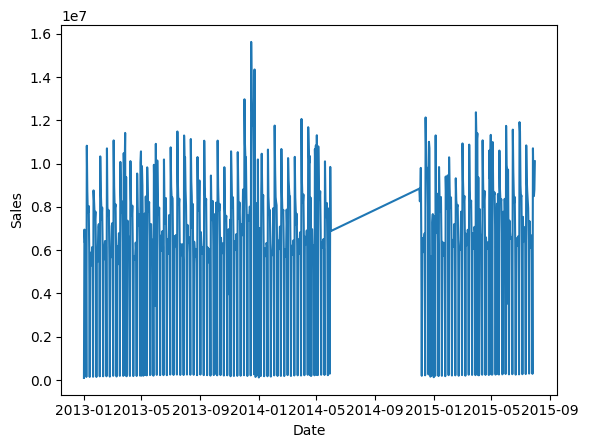

In [51]:
temp = train.loc[~((train['Date']>= "2014-06-01")&(train['Date'] <= "2014-12-01"))].copy()
train_agg = temp.groupby('Date')['Sales'].sum().reset_index()
sns.lineplot(data=train_agg, x='Date', y='Sales');

In [115]:
test_agg = test.groupby(["Date"]).first().reset_index().drop(['Id'], axis=1)
test_dates = test_agg[["Date"]]
test_agg[:5]

,Date,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekDay
0,2015-08-01,1,6,1.0,0,0,1,2015,8,1,5
1,2015-08-02,1,7,0.0,0,0,1,2015,8,2,6
2,2015-08-03,1,1,1.0,1,0,1,2015,8,3,0
3,2015-08-04,1,2,1.0,1,0,1,2015,8,4,1
4,2015-08-05,1,3,1.0,1,0,1,2015,8,5,2


In [116]:
y_train = train_agg['Sales']
X_train = train_agg.drop(['Sales'], axis=1)
X_test = test_agg

In [117]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["Month"] = df["Date"].dt.month
    new_df["Month_sin"] = np.sin(new_df['Month'] * (2 * np.pi / 12))
    new_df["Month_cos"] = np.cos(new_df['Month'] * (2 * np.pi / 12))
    new_df["Day"] = df["Date"].dt.day
    new_df["Day_sin"] = np.sin(new_df['Day'] * (2 * np.pi / 12))
    new_df["DayOfWeek"] = df["Date"].dt.dayofweek
    new_df["DayOfWeek"] = new_df["DayOfWeek"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["DayOfYear"] = df["Date"].dt.dayofyear
        
    new_df["Year"] = df["Date"].dt.year

    new_df = new_df.drop(columns=["Date","Month","Day", "DayOfYear"])

    return new_df

In [118]:
X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

In [119]:
feat = ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'WeekDay']
X_test = X_test.drop(feat, axis=1)

In [123]:
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [128]:
def train_and_predict(X_train, y_train, X_test):
    preds_lst = []
    n_splits = 3
    kf = GroupKFold(n_splits=n_splits)
    scores = []
    train_scores = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.Year)):
        model = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[train_idx]), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_train.iloc[val_idx]), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train_scaled, y_train.iloc[train_idx])
        preds_lst.append(model.predict(X_test_scaled))
        train_scores[val_idx] = model.predict(X_val_scaled)
        sc = model.score(X_val_scaled, y_train.iloc[val_idx])
        scores.append(sc)
        print(f"Fold {fold}: Score = {sc}")

    mean_score = np.mean(scores)
    print("Mean score:", mean_score)
    return preds_lst, train_scores

preds_lst, train_scores = train_and_predict(X_train, y_train, X_test)
train_pred = pd.DataFrame()
train_pred['Date'] = train_agg['Date']
train_pred['Sales'] = train_scores

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 393, number of used features: 5
[LightGBM] [Info] Start training from score 6438368.488550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [132]:
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns=['2013', '2014', '2015'])
preds_df['Sales'] = preds_df.mean(axis=1)
test_dates["Sales"] = preds_df['Sales']

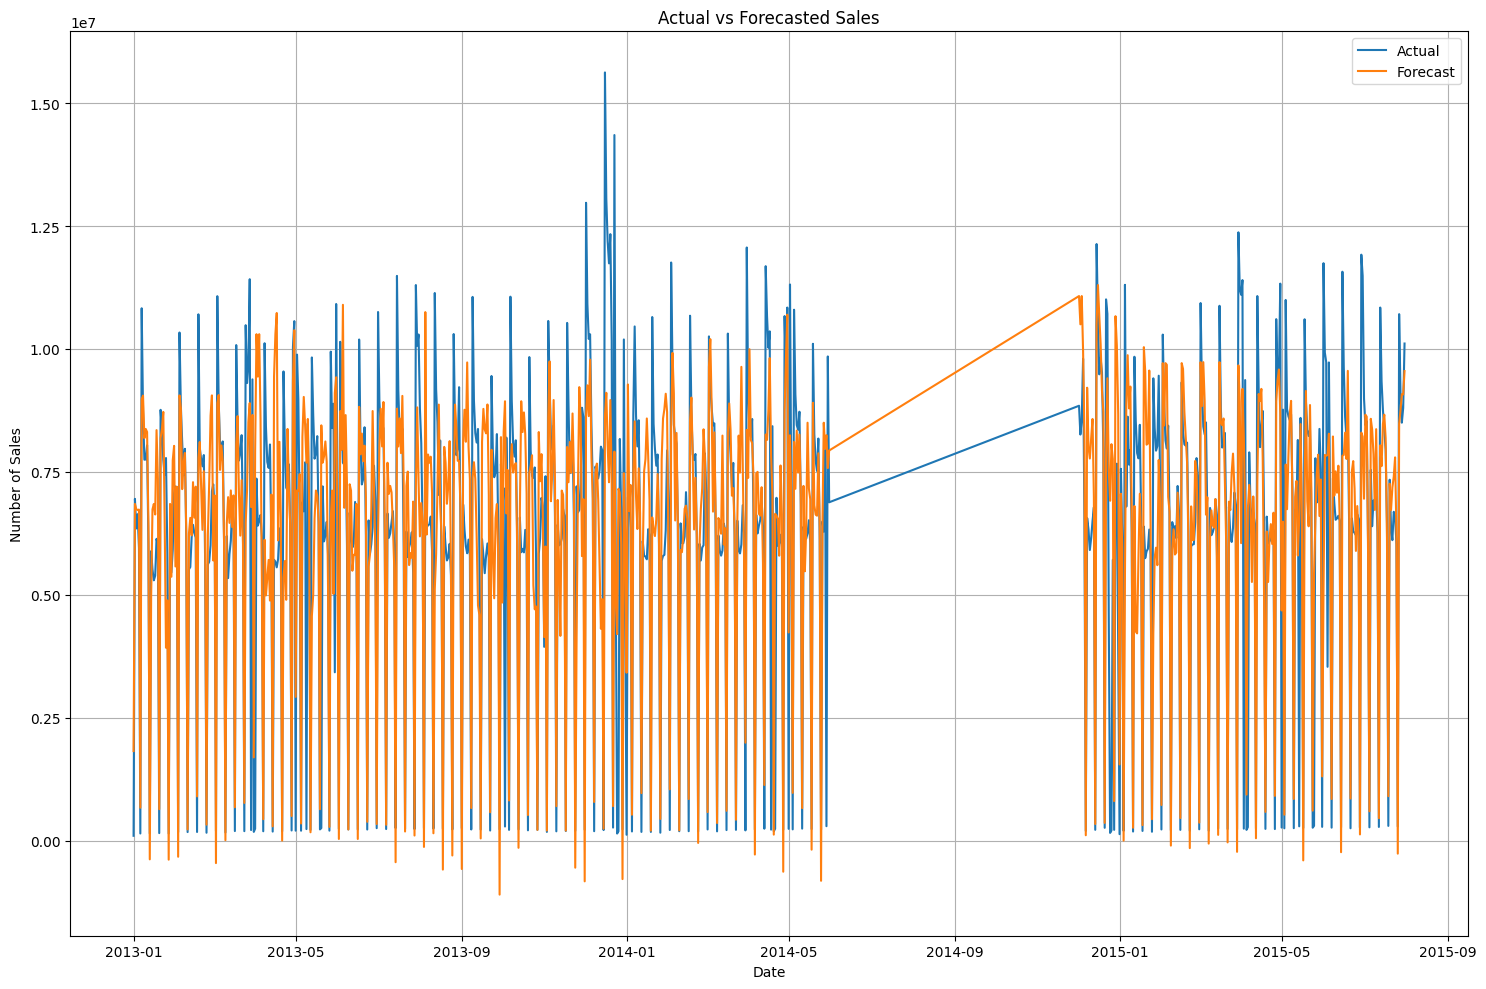

In [134]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="Date", y="Sales", label='Actual')
sns.lineplot(data=train_pred, x='Date', y='Sales', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

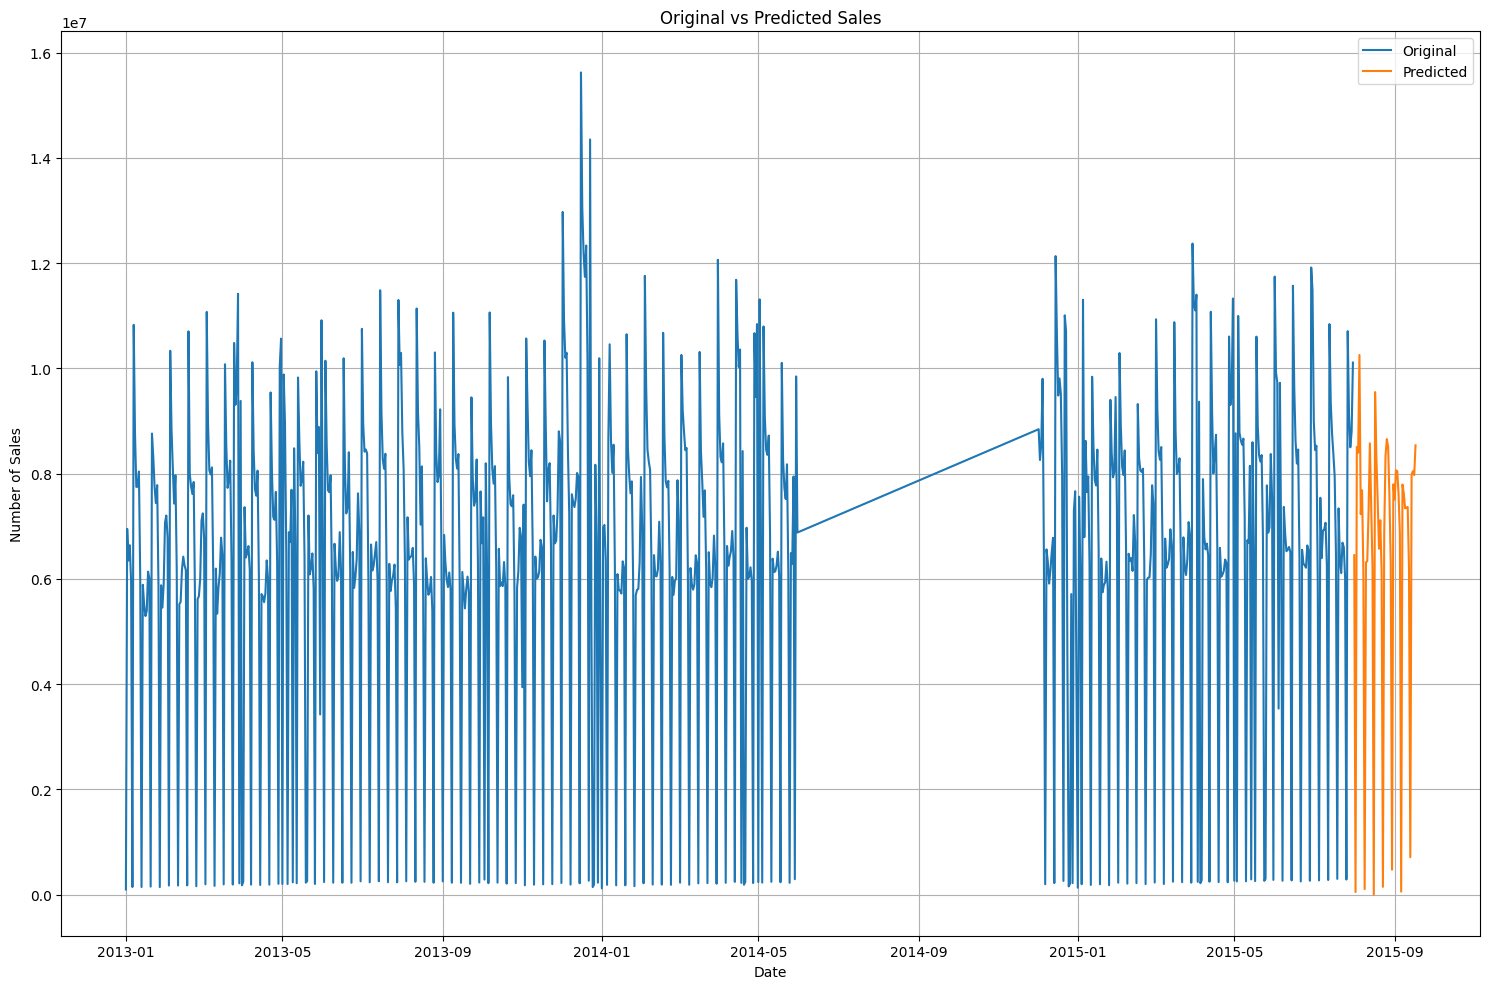

In [135]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="Date", y="Sales", label='Original')
sns.lineplot(data=test_dates, x="Date", y="Sales", label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Original vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
test_data = pd.merge(test, test_dates, how="left")
test_data

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekDay,Sales
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,3,8.537023e+06
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,3,8.537023e+06
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,3,8.537023e+06
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,3,8.537023e+06
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,3,8.537023e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,2015,8,1,5,6.449969e+06
41084,41085,1112,6,2015-08-01,1.0,0,0,0,2015,8,1,5,6.449969e+06
41085,41086,1113,6,2015-08-01,1.0,0,0,0,2015,8,1,5,6.449969e+06
41086,41087,1114,6,2015-08-01,1.0,0,0,0,2015,8,1,5,6.449969e+06


In [142]:
def disaggregate_forecast(df, original_data):

    new_df = df.copy()
    
    # Compute weights and check for zero total sales
    total_num_sold = original_data["Sales"].sum()

    stores_weights = original_data.groupby("Store")["Sales"].sum() / total_num_sold
                
    for store in stores_weights.index:
        new_df.loc[new_df["Store"] == store, "Sales"] *= stores_weights[store]
    

    new_df["Sales"] = new_df["Sales"].round()

    return new_df

In [141]:
store_weights = train.groupby("Store")["Sales"].sum()/train["Sales"].sum()

In [143]:
final_df = disaggregate_forecast(test_data,train)
final_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekDay,Sales
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,3,5403.0
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,3,7861.0
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,3,10073.0
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,3,6313.0
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,3,7431.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,2015,8,1,5,4493.0
41084,41085,1112,6,2015-08-01,1.0,0,0,0,2015,8,1,5,8757.0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,2015,8,1,5,5707.0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,2015,8,1,5,17794.0


In [146]:
submission = pd.read_csv("./sample_submission.csv")
submission["Sales"] = final_df["Sales"]

submission.head()
submission.to_csv('submission.csv', index = False)